# Short Term Memory タスク

## インポート

In [1]:
import os
import sys
import json
import gc
from colorama import Fore, Style
import argparse

import numpy as np
import torch
from tqdm import tqdm

In [2]:
from model.operators import construct_hamiltonian
from model.density_mat import rho_init
from model.Qreservoir import run_reservoir_with_states
from utils.torch_reg import TorchLinearRegression, r2_score

In [3]:
# Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set device-specific optimizations
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

Using device: cpu


## パラメータ設定

In [4]:
# Parameters
N = 6
J_scale, h_scale = 1.0, 0.5
tau = 0.5
Delta = 1.0
V = 20

params = {"N": N, "J_scale": J_scale, "h_scale": h_scale, "tau": tau, "Delta": Delta, "V": V}

print(Fore.LIGHTGREEN_EX + f"Params: {params}" + Style.RESET_ALL)

Params: {'N': 6, 'J_scale': 1.0, 'h_scale': 0.5, 'tau': 0.5, 'Delta': 1.0, 'V': 20}


## ハミルトニアン、初期状態設定

In [5]:
seed = 42

# Generate inputs - keep them smaller initially for memory efficiency
np.random.seed(42)
s_train = np.random.uniform(0, 1, int(3e3))
s_valid = np.random.uniform(0, 1, int(1e3))
s_wo    = np.random.uniform(0, 1, int(1e3))

# Build Hamiltonian & unitaries
np.random.seed(seed)
Js = np.random.uniform(-J_scale/2, J_scale/2, (N, N))
Js = np.triu(Js) + np.triu(Js, 1).T
hs = np.ones(N) * h_scale
Ham = construct_hamiltonian(Js, hs, Delta, device=device)

# Optimize eigendecomposition
with torch.no_grad():
    eigvals, eigvecs = torch.linalg.eigh(Ham)
    exp_diag = torch.exp(-1j*(tau/V)*eigvals)
    U_sub = eigvecs @ torch.diag(exp_diag) @ eigvecs.conj().T

# Cleanup intermediate tensors
del Ham, eigvals, eigvecs, exp_diag
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

# Initialize density matrix once
rho_initial = rho_init(N, device=device)

## リザバーステップ（washout --> train --> valid） 

In [6]:
# Washout: get final state only
with torch.no_grad():
    _, rho_wo_last = run_reservoir_with_states(
        U_sub, s_wo, N, rho_initial, V,
        mode="Z&ZZ", input_enc="sqrt", device=device
    )

# Train: get features and final state
with torch.no_grad():
    feat_tr, rho_tr_last = run_reservoir_with_states(
        U_sub, s_train, N, rho_wo_last, V,
        mode="Z&ZZ", input_enc="sqrt", device=device
    )

# Move to CPU for sklearn processing
X_tr = feat_tr.cpu().numpy().reshape(int(3e3), -1)
del feat_tr
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

# Validation: get features
with torch.no_grad():
    feat_va, _ = run_reservoir_with_states(
        U_sub, s_valid, N, rho_tr_last, V,
        mode="Z&ZZ", input_enc="sqrt", device=device
    )

# Move to CPU
X_va = feat_va.cpu().numpy().reshape(int(1e3), -1)
del feat_va, rho_wo_last, rho_tr_last
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

Reservoir evolution:   0%|          | 0/1000 [00:00<?, ?step/s]

Reservoir evolution: 100%|██████████| 1000/1000 [00:06<00:00, 155.33step/s]


## Memory Capacity

In [8]:
max_delay = 200

# Compute MC with optimized regression
mc = []
reg = TorchLinearRegression(alpha=0.001)

for delay in tqdm(range(1, max_delay+1), desc="Calc MC", unit="delay"):
    Y_tr = s_train[:-delay]
    Y_va = s_valid[:-delay]
    
    # Fit and predict in one go to reduce overhead
    reg.fit(X_tr[delay:], Y_tr)
    pred = reg.predict(X_va[delay:])
    mc.append(r2_score(Y_va, pred))


Calc MC: 100%|██████████| 200/200 [00:01<00:00, 135.95delay/s]


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

pub_rc = {
    # フォントと LaTeX 数式
    "font.family":        "Times New Roman",
    "font.weight":        "bold",
    "font.size":          10,
    "text.usetex":        True,
    # LaTeX で Times 系を使う
    "text.latex.preamble": r"\usepackage{newtxtext}\usepackage{newtxmath}\usepackage{amsmath}\usepackage{bm}",

    # 図の全体サイズ・解像度
    "figure.figsize":     (5, 3),    # inch
    "figure.dpi":         300,

    # 軸・目盛り
    "axes.linewidth":     0.8,
    "axes.labelsize":     10,        # 軸ラベルのフォントサイズ
    "xtick.direction":    "in",
    "ytick.direction":    "in",
    "xtick.labelsize":    8,
    "ytick.labelsize":    8,
    "xtick.major.size":   4,
    "ytick.major.size":   4,
    "xtick.minor.size":   2,
    "ytick.minor.size":   2,
    "xtick.major.width":  0.8,
    "ytick.major.width":  0.8,
    "xtick.minor.width":  0.6,
    "ytick.minor.width":  0.6,
    "axes.grid":          False,

    # 線とマーカー
    "lines.linewidth":    1.0,
    "lines.markersize":   6,

    # 図の余白
    "figure.autolayout":  True,
}
plt.rcParams.update(pub_rc)

In [10]:
X_va.shape

(1000, 421)

Total MC: 12.26
Total Reservoir Size: 421
MC per size: 0.03


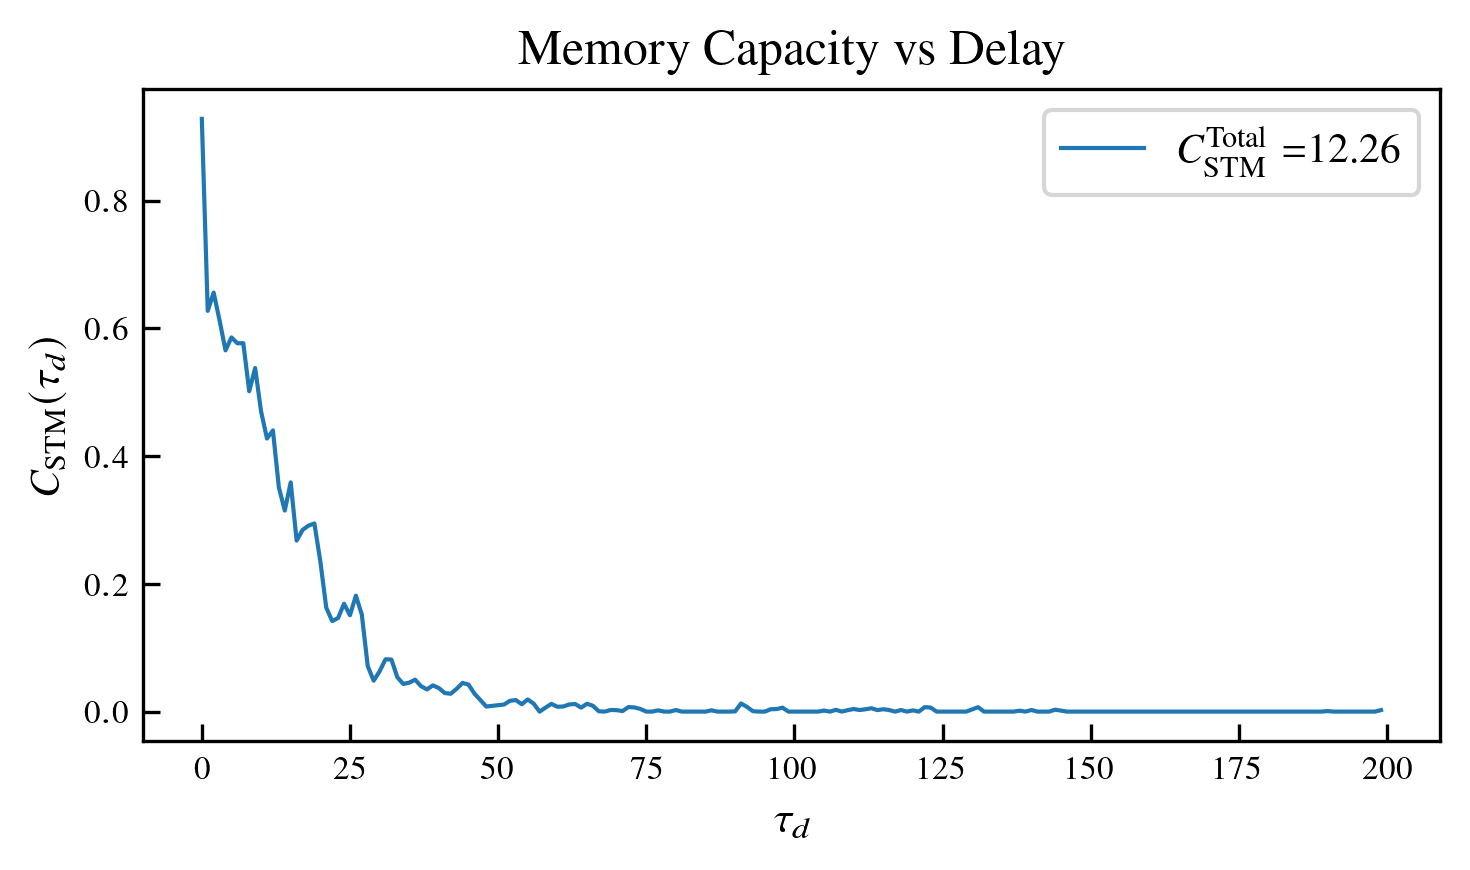

In [11]:
mc_nonneg = np.array(mc).clip(0, 1)

total_mc = np.sum(mc_nonneg)

total_reservoir_size = X_va.shape[1]

print(f"Total MC: {total_mc:.2f}")
print(f"Total Reservoir Size: {total_reservoir_size}")

print(f"MC per size: {total_mc / total_reservoir_size:.2f}")

plt.figure()
plt.plot(mc_nonneg, label=r'$C_{\text{STM}}^{\text{Total}}=$' + f'{total_mc:.2f}')
plt.xlabel(r'$\tau_d$')
plt.ylabel(r'$C_{\text{STM}}(\tau_d)$')
plt.title('Memory Capacity vs Delay')
plt.legend()
plt.show()

# NARMA タスク

## インポート

In [28]:
import os
import sys
import json
import gc
from colorama import Fore, Style
import argparse

import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [29]:
from utils.narma_data import generate_narma_data
from model.operators import construct_hamiltonian
from model.density_mat import rho_init
from model.Qreservoir import run_reservoir_with_states
from utils.torch_reg import TorchLinearRegression, r2_score

In [30]:
# Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set device-specific optimizations
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

Using device: cpu


## パラメータ設定

In [31]:
# Parameters
N = 6
J_scale, h_scale = 1.0, 0.5
tau = 0.5
Delta = 1.0
V = 20

params = {"N": N, "J_scale": J_scale, "h_scale": h_scale, "tau": tau, "Delta": Delta, "V": V}

print(Fore.LIGHTGREEN_EX + f"Params: {params}" + Style.RESET_ALL)

Params: {'N': 6, 'J_scale': 1.0, 'h_scale': 0.5, 'tau': 0.5, 'Delta': 1.0, 'V': 20}


## ハミルトニアン、初期状態設定

In [32]:
seed = 42

order = 5

T_train = 3000
T_valid = 1000
T_washout = 1000

# Generate inputs - keep them smaller initially for memory efficiency
train_U, train_Y, valid_U, valid_Y = generate_narma_data(order, T_train, T_valid, T_washout)

# MinMaxScaler: trainでtransform_fitしてvalidにtransformする
scaler = MinMaxScaler()
train_U = scaler.fit_transform(train_U)
valid_U = scaler.transform(valid_U)

washout_U, washout_Y = train_U[:T_washout], train_Y[:T_washout]
train_U, train_Y = train_U[T_washout:], train_Y[T_washout:]
valid_U, valid_Y = valid_U, valid_Y

print(train_U.shape, valid_U.shape, washout_U.shape)
assert train_U.shape[0] == T_train, f"train_U.shape[0] = {train_U.shape[0]}, T_train = {T_train}"
assert valid_U.shape[0] == T_valid, f"valid_U.shape[0] = {valid_U.shape[0]}, T_valid = {T_valid}"
assert washout_U.shape[0] == T_washout, f"washout_U.shape[0] = {washout_U.shape[0]}, T_washout = {T_washout}"


# Build Hamiltonian & unitaries
np.random.seed(seed)
Js = np.random.uniform(-J_scale/2, J_scale/2, (N, N))
Js = np.triu(Js) + np.triu(Js, 1).T
hs = np.ones(N) * h_scale
Ham = construct_hamiltonian(Js, hs, Delta, device=device)

# Optimize eigendecomposition
with torch.no_grad():
    eigvals, eigvecs = torch.linalg.eigh(Ham)
    exp_diag = torch.exp(-1j*(tau/V)*eigvals)
    U_sub = eigvecs @ torch.diag(exp_diag) @ eigvecs.conj().T

# Cleanup intermediate tensors
del Ham, eigvals, eigvecs, exp_diag
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

# Initialize density matrix once
rho_initial = rho_init(N, device=device)

(3000, 1) (1000, 1) (1000, 1)


## リザバーステップ（washout --> train --> valid） 

In [33]:
# Washout: get final state only
with torch.no_grad():
    _, rho_wo_last = run_reservoir_with_states(
        U_sub, washout_U, N, rho_initial, V,
        mode="Z&ZZ", input_enc="sqrt", device=device
    )

# Train: get features and final state
with torch.no_grad():
    feat_tr, rho_tr_last = run_reservoir_with_states(
        U_sub, train_U, N, rho_wo_last, V,
        mode="Z&ZZ", input_enc="sqrt", device=device
    )

# Move to CPU for sklearn processing
X_tr = feat_tr.cpu().numpy().reshape(int(T_train), -1)
del feat_tr
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

# Validation: get features
with torch.no_grad():
    feat_va, _ = run_reservoir_with_states(
        U_sub, valid_U, N, rho_tr_last, V,
        mode="Z&ZZ", input_enc="sqrt", device=device
    )

# Move to CPU
X_va = feat_va.cpu().numpy().reshape(int(T_valid), -1)
del feat_va, rho_wo_last, rho_tr_last
gc.collect()
if device.type == 'cuda': torch.cuda.empty_cache()

Reservoir evolution: 100%|██████████| 1000/1000 [00:09<00:00, 106.82step/s]


In [34]:
reg = TorchLinearRegression(alpha=0.001)

reg.fit(X_tr, train_Y)
train_Y_pred = reg.predict(X_tr).cpu().numpy()
valid_Y_pred = reg.predict(X_va).cpu().numpy()

RMSE_train = np.sqrt(np.mean((train_Y - train_Y_pred)**2))
RMSE_valid = np.sqrt(np.mean((valid_Y - valid_Y_pred)**2))

r2_train = r2_score(train_Y, train_Y_pred)
r2_valid = r2_score(valid_Y, valid_Y_pred)

print(f"RMSE_train: {RMSE_train:.4f}", f"R2_train: {r2_train:.4f}")
print(f"RMSE_valid: {RMSE_valid:.4f}", f"R2_valid: {r2_valid:.4f}")

RMSE_train: 0.1145 R2_train: 0.7768
RMSE_valid: 0.1081 R2_valid: 0.7601


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

pub_rc = {
    # フォントと LaTeX 数式
    "font.family":        "Times New Roman",
    "font.weight":        "bold",
    "font.size":          10,
    "text.usetex":        True,
    # LaTeX で Times 系を使う
    "text.latex.preamble": r"\usepackage{newtxtext}\usepackage{newtxmath}\usepackage{amsmath}\usepackage{bm}",

    # 図の全体サイズ・解像度
    "figure.figsize":     (5, 3),    # inch
    "figure.dpi":         300,

    # 軸・目盛り
    "axes.linewidth":     0.8,
    "axes.labelsize":     10,        # 軸ラベルのフォントサイズ
    "xtick.direction":    "in",
    "ytick.direction":    "in",
    "xtick.labelsize":    8,
    "ytick.labelsize":    8,
    "xtick.major.size":   4,
    "ytick.major.size":   4,
    "xtick.minor.size":   2,
    "ytick.minor.size":   2,
    "xtick.major.width":  0.8,
    "ytick.major.width":  0.8,
    "xtick.minor.width":  0.6,
    "ytick.minor.width":  0.6,
    "axes.grid":          False,

    # 線とマーカー
    "lines.linewidth":    1.0,
    "lines.markersize":   6,

    # 図の余白
    "figure.autolayout":  True,
}
plt.rcParams.update(pub_rc)

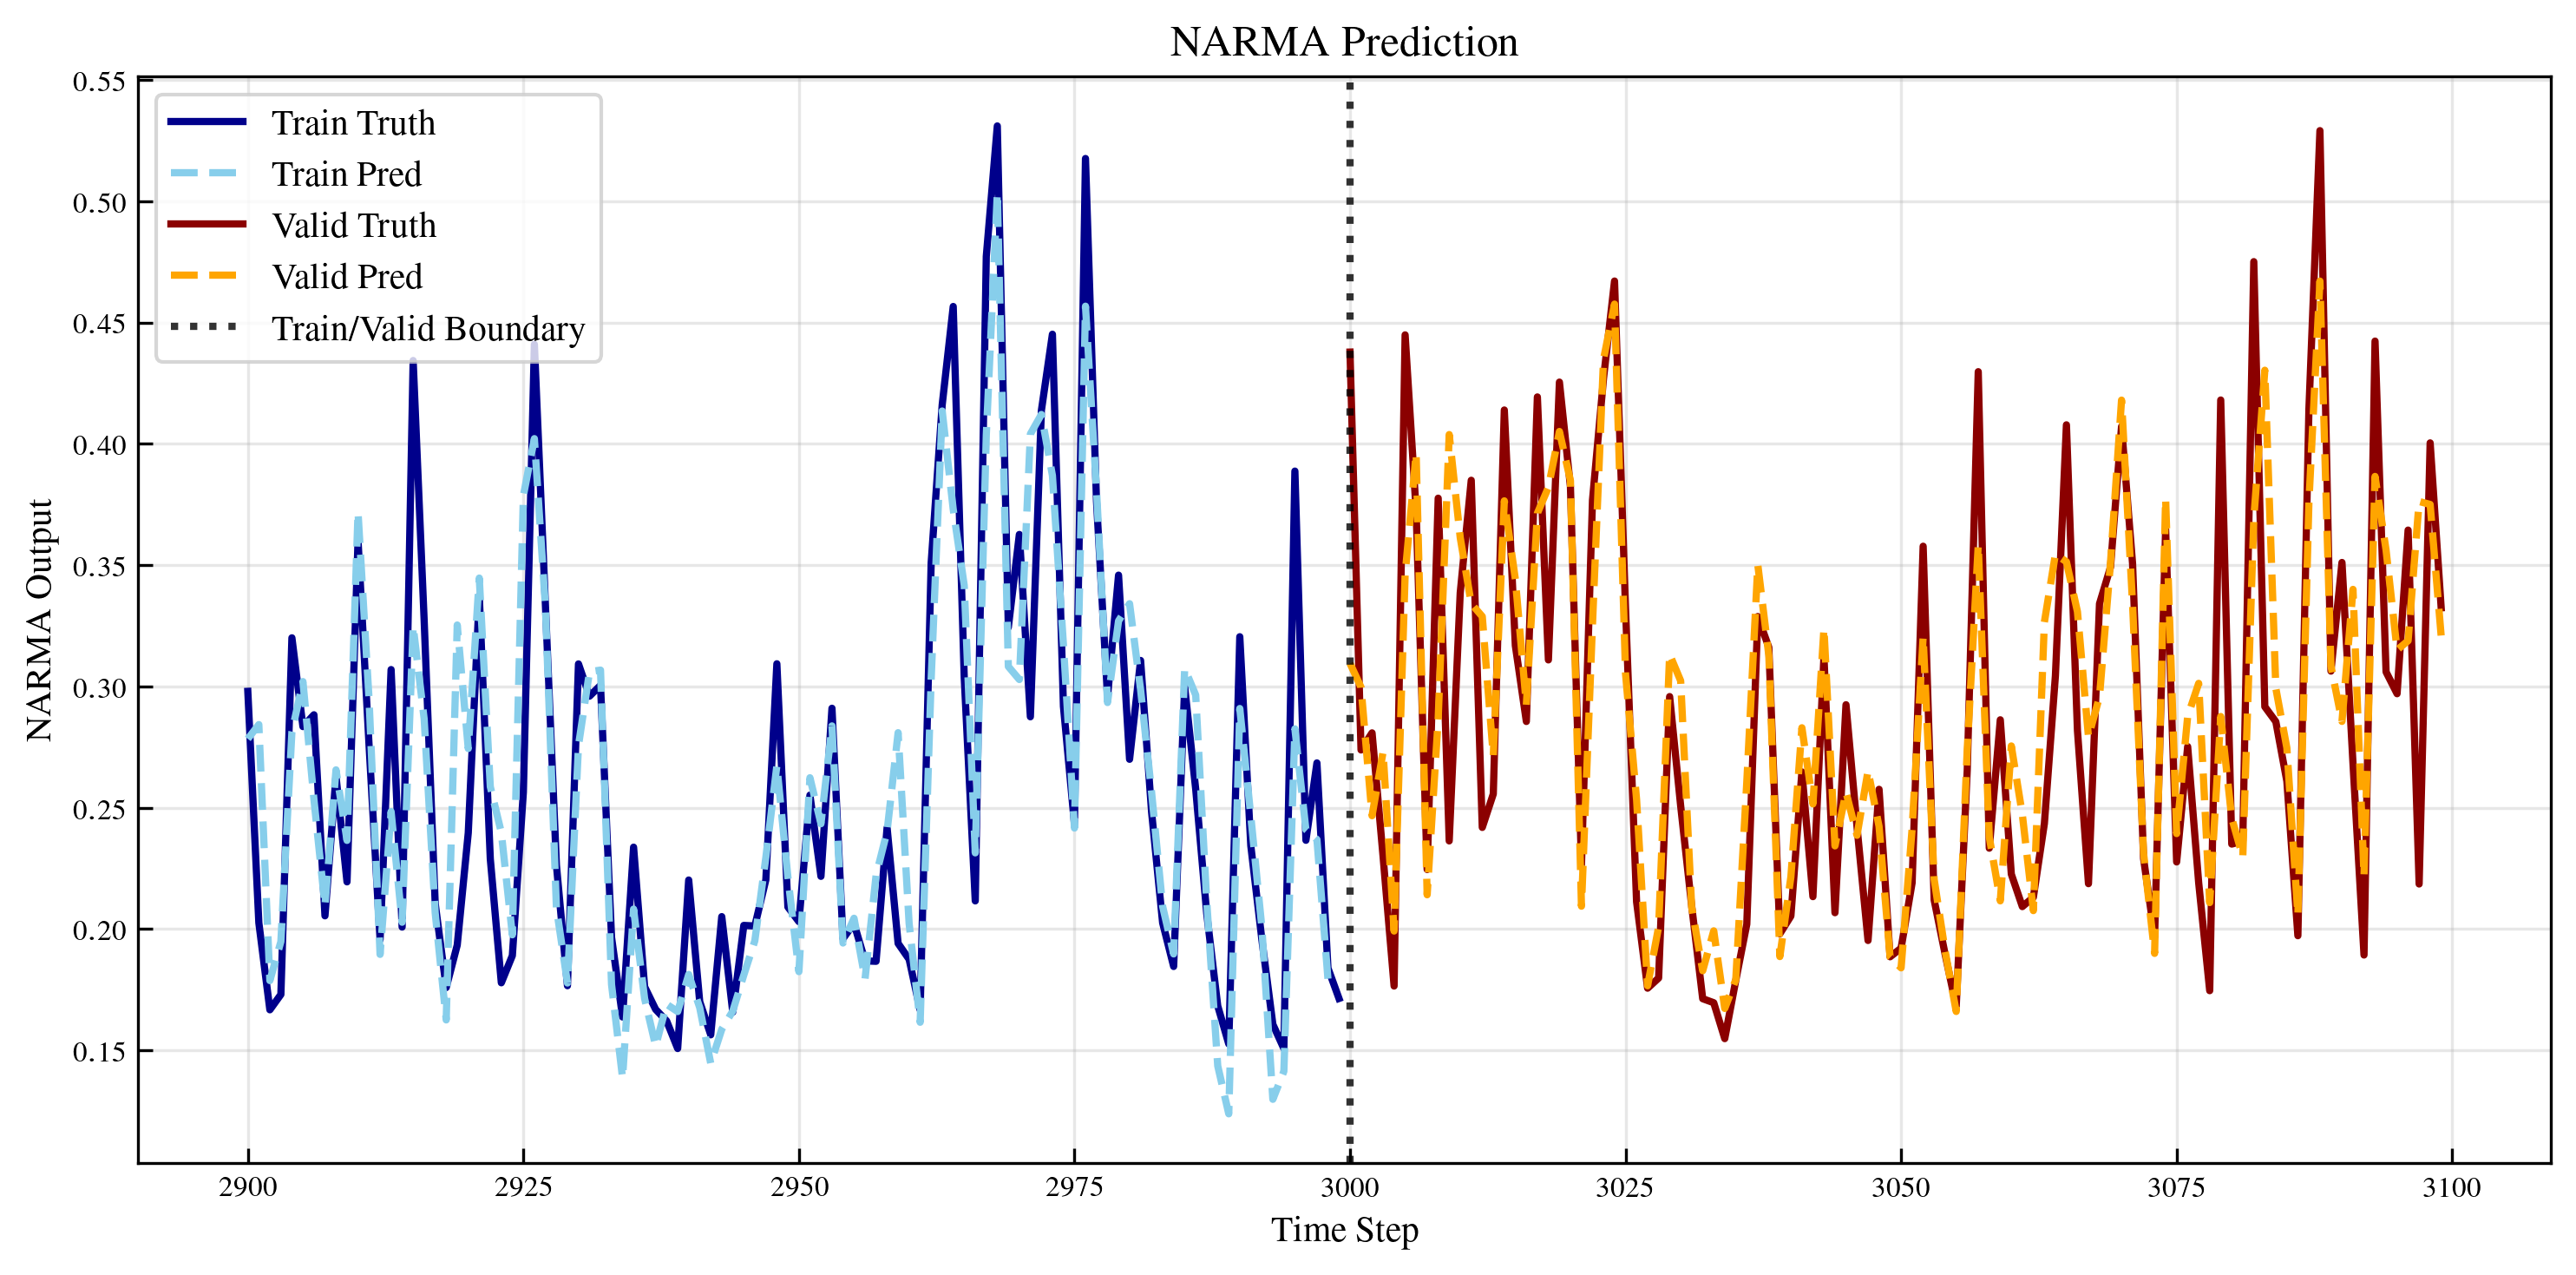

In [40]:
# Plot train and validation predictions around the boundary
boundary_idx = len(train_Y)  # Index where train ends and valid begins
plot_range = 100  # Number of points to show on each side of boundary

# Determine plot indices
start_idx = max(0, boundary_idx - plot_range)
end_idx = min(len(train_Y) + len(valid_Y), boundary_idx + plot_range)

# Create time indices for plotting
time_train = np.arange(start_idx, min(boundary_idx, end_idx))
time_valid = np.arange(max(boundary_idx, start_idx), end_idx)

# Extract data for plotting
if start_idx < boundary_idx:
    train_truth_plot = train_Y[start_idx:min(boundary_idx, end_idx)]
    train_pred_plot = train_Y_pred[start_idx:min(boundary_idx, end_idx)]
else:
    train_truth_plot = np.array([])
    train_pred_plot = np.array([])

if end_idx > boundary_idx:
    valid_start = max(0, start_idx - boundary_idx)
    valid_end = end_idx - boundary_idx
    valid_truth_plot = valid_Y[valid_start:valid_end]
    valid_pred_plot = valid_Y_pred[valid_start:valid_end]
else:
    valid_truth_plot = np.array([])
    valid_pred_plot = np.array([])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot training data
if len(train_truth_plot) > 0:
    ax.plot(time_train, train_truth_plot, color='darkblue', linestyle='-', label='Train Truth', linewidth=2.0)
    ax.plot(time_train, train_pred_plot, color='skyblue', linestyle='--', label='Train Pred', linewidth=2.0)

# Plot validation data
if len(valid_truth_plot) > 0:
    ax.plot(time_valid, valid_truth_plot, color='darkred', linestyle='-', label='Valid Truth', linewidth=2.0)
    ax.plot(time_valid, valid_pred_plot, color='orange', linestyle='--', label='Valid Pred', linewidth=2.0)

# Add vertical line at boundary
ax.axvline(x=boundary_idx, color='black', linestyle=':', linewidth=2.0, alpha=0.8, label='Train/Valid Boundary')

# Formatting
ax.set_xlabel('Time Step')
ax.set_ylabel('NARMA Output')
ax.set_title('NARMA Prediction')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
